<a href="https://colab.research.google.com/github/namibarsbold/STATS201-Course-project/blob/main/Week_2_Preliminary_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

# Authenticate and initialize Earth Engine (run once per runtime)
ee.Authenticate()
ee.Initialize(project='week-2-485101')

# Country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# VIIRS annual nighttime lights (2020–2022 inclusive)
dataset = (ee.ImageCollection('NOAA/VIIRS/DNB/ANNUAL_V22')
           .filter(ee.Filter.date('2020-01-01', '2023-01-01'))
           .select('maximum'))

def country_stats(image):
    """Compute country-level mean and stdDev for one year of VIIRS imagery."""
    stats = image.reduceRegions(
        collection=countries,
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
        scale=500
    )
    year = ee.Date(image.get('system:time_start')).get('year')
    return stats.map(lambda f: f.set('year', year))

country_features = dataset.map(country_stats).flatten()

# Select columns to export
export_table = country_features.select(['country_na', 'mean', 'stdDev', 'year'])

# Export to Google Drive folder "earthengine"
task = ee.batch.Export.table.toDrive(
    collection=export_table,
    description='viirs_country_features',
    folder='earthengine',
    fileNamePrefix='viirs_country_features',
    fileFormat='CSV'
)

task.start()
print("Export started:", task.status())


Export started: {'state': 'READY', 'description': 'viirs_country_features', 'priority': 100, 'creation_timestamp_ms': 1769308692228, 'update_timestamp_ms': 1769308692228, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'X2KQRV43A76IMRN7IGP7DQAH', 'name': 'projects/week-2-485101/operations/X2KQRV43A76IMRN7IGP7DQAH'}


In [2]:
# OPTIONAL TASK MONITOR
import time

while True:
    s = task.status()
    print("Task state:", s['state'])
    if s['state'] in ['COMPLETED', 'FAILED', 'CANCELLED']:
        print(s)
        break
    time.sleep(20)


Task state: RUNNING
Task state: RUNNING
Task state: RUNNING
Task state: RUNNING
Task state: RUNNING
Task state: COMPLETED
{'state': 'COMPLETED', 'description': 'viirs_country_features', 'priority': 100, 'creation_timestamp_ms': 1769308692228, 'update_timestamp_ms': 1769308835935, 'start_timestamp_ms': 1769308705570, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/#folders/1Vax5PX_7D8Qrxk0S9cBhdH3W--pho7QK'], 'attempt': 1, 'batch_eecu_usage_seconds': 779.7576293945312, 'id': 'X2KQRV43A76IMRN7IGP7DQAH', 'name': 'projects/week-2-485101/operations/X2KQRV43A76IMRN7IGP7DQAH'}


In [3]:
# Imports + mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Mounted at /content/drive


In [4]:
# Load the exported CSV
csv_path = '/content/drive/MyDrive/earthengine/viirs_country_features.csv'
df = pd.read_csv(csv_path)

print(df.shape)
print(df.columns)
df.head()


(312, 6)
Index(['system:index', 'country_na', 'mean', 'stdDev', 'year', '.geo'], dtype='object')


,system:index,country_na,mean,stdDev,year,.geo
0,20220101_00000000000000000000,Chad,0.519822,5.614095,2022,"{""type"":""Polygon"",""coordinates"":[[[15.79989695..."
1,20220101_00000000000000000014,Malawi,0.568001,1.873316,2022,"{""type"":""MultiPolygon"",""coordinates"":[[[[34.61..."
2,20220101_00000000000000000015,Zambia,0.702381,4.475740,2022,"{""type"":""Polygon"",""coordinates"":[[[25.26174829..."
3,20220101_00000000000000000016,Zimbabwe,0.700753,3.428186,2022,"{""type"":""Polygon"",""coordinates"":[[[25.26291968..."
4,20220101_00000000000000000017,Botswana,0.657821,6.321024,2022,"{""type"":""Polygon"",""coordinates"":[[[19.99891705..."


In [5]:
# Clean columns and create modeling data set
# Rename to clearer names
df = df.rename(columns={'mean': 'mean_rad', 'stdDev': 'sd_rad'})

# Keep only what you need for baseline model
df_model = df[['country_na', 'year', 'mean_rad', 'sd_rad']].dropna().copy()

print("df_model shape:", df_model.shape)
df_model.head()


df_model shape: (309, 4)


,country_na,year,mean_rad,sd_rad
0,Chad,2022,0.519822,5.614095
1,Malawi,2022,0.568001,1.873316
2,Zambia,2022,0.702381,4.475740
3,Zimbabwe,2022,0.700753,3.428186
4,Botswana,2022,0.657821,6.321024


In [6]:
# Creating the binary labeling
threshold = df_model['sd_rad'].median()
df_model['label'] = (df_model['sd_rad'] > threshold).astype(int)

print("Label counts:\n", df_model['label'].value_counts())


Label counts:
 label
0    155
1    154
Name: count, dtype: int64


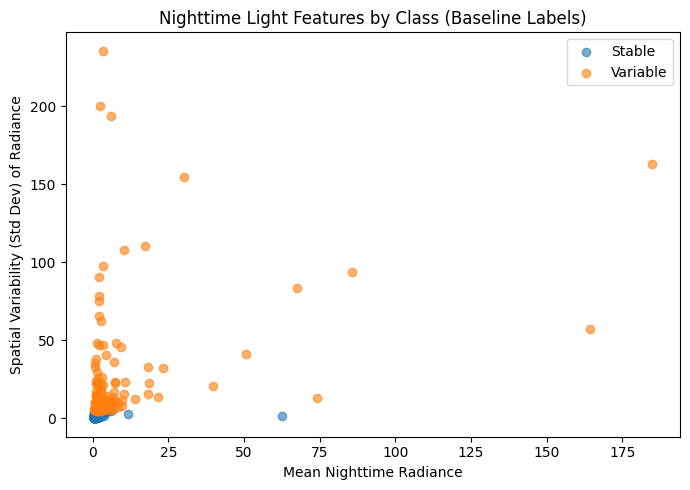

In [7]:
# Figure 1: Scatter
plt.figure(figsize=(7, 5))
for val, name in [(0, "Stable"), (1, "Variable")]:
    sub = df_model[df_model['label'] == val]
    plt.scatter(sub['mean_rad'], sub['sd_rad'], alpha=0.6, label=name)

plt.xlabel("Mean Nighttime Radiance")
plt.ylabel("Spatial Variability (Std Dev) of Radiance")
plt.title("Nighttime Light Features by Class (Baseline Labels)")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Test/train split and logistic regression (preliminary - Nami)
X = df_model[['mean_rad', 'sd_rad']]
y = df_model['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8602150537634409

Classification report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       1.00      0.72      0.84        46

    accuracy                           0.86        93
   macro avg       0.89      0.86      0.86        93
weighted avg       0.89      0.86      0.86        93



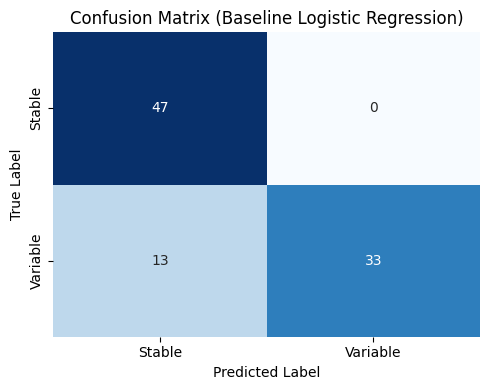

In [10]:
# Figure 2: Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Stable', 'Variable'],
    yticklabels=['Stable', 'Variable']
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Baseline Logistic Regression)')
plt.tight_layout()
plt.show()


In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=export_table,
    description='viirs_country_features',
    folder='earthengine',
    fileNamePrefix='viirs_country_features',
    fileFormat='CSV'
)

task.start()